Fitting 5 folds for each of 50 candidates, totalling 250 fits


/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
130 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/base.py", line 66

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=80; total time=   0.0s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=60; total time=  47.5s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=110; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  53.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=90

/users/barmanjy/.local/lib/python3.10/site-packages/shap/plots/_beeswarm.py:962: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


ValueError: Length of values (63678) does not match length of index (63680)

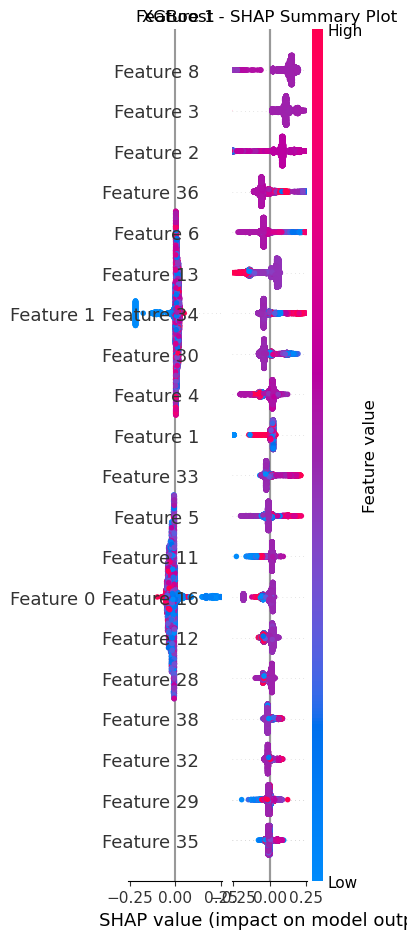

In [3]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from collections import Counter

# Function to load data
def load_data_in_chunks(file_path, chunk_size=1000):
    return pd.read_csv(file_path, engine='python', encoding='utf-8', chunksize=chunk_size)

# Preprocessing function
def preprocess_data(metadata_path, data_path, additional_datasets=None):
    metadata_df = pd.read_csv(metadata_path, sep='\t')
    scRNA_data = pd.concat(load_data_in_chunks(data_path)).transpose()

    metadata_df.index.rename('cell', inplace=True)
    metadata_df.reset_index(inplace=True)
    metadata_df['cell'] = metadata_df['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()
    scRNA_data.reset_index(inplace=True)
    scRNA_data.rename(columns={'index': 'cell'}, inplace=True)
    scRNA_data['cell'] = scRNA_data['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()

    common_cells = set(metadata_df['cell']).intersection(set(scRNA_data['cell']))

    filtered_metadata_df = metadata_df[metadata_df['cell'].isin(common_cells)]
    filtered_scRNA_data = scRNA_data[scRNA_data['cell'].isin(common_cells)]

    merged_data = pd.merge(filtered_scRNA_data, filtered_metadata_df[['cell', 'sample_name', 'sample_type']], on='cell', how='inner')

    if additional_datasets:
        for file_path, sample_type in additional_datasets:
            additional_data = pd.concat(load_data_in_chunks(file_path)).transpose()
            additional_data.reset_index(inplace=True)
            additional_data.rename(columns={'index': 'cell'}, inplace=True)
            additional_data['cell'] = additional_data['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()
            additional_data['sample_type'] = sample_type
            merged_data = pd.concat([merged_data, additional_data], ignore_index=True, sort=False)

    X = merged_data.drop(columns=['cell', 'sample_name', 'sample_type'], errors='ignore')
    X.columns = X.columns.astype(str)
    X = X.apply(pd.to_numeric, errors='coerce')

    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    y = merged_data['sample_type']
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y, merged_data, label_encoder, scaler

metadata_path = '/scratch/project_2010376/GSE150949_metaData_with_lineage.txt'
data_path = '/scratch/project_2010376/normalized_GSE150949_pc9_count.csv'
additional_datasets = [
    ('/scratch/project_2010376/GSM4869650_xCtrl.dge.csv', 'Non-Persister'),
    ('/scratch/project_2010376/GSM4869652_xOsi.dge.csv', 'Persister'),
    ('/scratch/project_2010376/GSM4869653_xOsiCriz.dge.csv', 'Persister'),
    ('/scratch/project_2010376/new_GSM4869650_xCtrl.dge.csv', 'Non-Persister'),
    ('/scratch/project_2010751/GSE134836_GSM3972651_PC9D0_untreated_filtered.csv', 'Non-Persister'),
    ('/scratch/project_2010751/GSE138693_GSM4116265_PC9_1_invitro_normalized_untreated.csv', 'Non-Persister'),
    ('/scratch/project_2010751/GSE134839_GSM3972657_PC90D0_untreated.dge.csv', 'Non-Persister'),
    ('/scratch/project_2010751/GSE149383_GSM3972669_D0_untreated.dge.csv', 'Non-Persister')
]

X, y, merged_data, label_encoder, scaler = preprocess_data(metadata_path, data_path, additional_datasets)

pca = PCA(n_components=100)  # Reduced number of components for efficiency
X_reduced = pca.fit_transform(X)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_reduced, y)

X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)
param_dist_rf = {
    'n_estimators': np.arange(50, 150, 10),
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# XGBoost Classifier
xgb_classifier = XGBClassifier(objective='binary:logistic', random_state=42)
param_dist_xgb = {
    'n_estimators': np.arange(50, 150, 10),
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'colsample_bytree': [0.3, 0.7],
    'subsample': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

# Randomized Search CV for Random Forest
random_search_rf = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist_rf, n_iter=50, 
                                      cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search_rf.fit(X_train, y_train)

best_rf = random_search_rf.best_estimator_

# Randomized Search CV for XGBoost
random_search_xgb = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=param_dist_xgb, n_iter=50, 
                                       cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)

best_xgb = random_search_xgb.best_estimator_

# SHAP Value Plotting
def plot_shap_values(model, X_test, model_name):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test, check_additivity=False)  # Disable additivity check to avoid errors

    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap.summary_plot(shap_values[1], X_test, show=False)
        plt.title(f'{model_name} - SHAP Summary Plot (Class 1)')
        plt.savefig(f'{model_name}_shap_summary_class1.png')
    else:
        shap.summary_plot(shap_values, X_test, show=False)
        plt.title(f'{model_name} - SHAP Summary Plot')
        plt.savefig(f'{model_name}_shap_summary.png')

plot_shap_values(best_rf, X_test, 'RandomForest')
plot_shap_values(best_xgb, X_test, 'XGBoost')

# Feature Importance Extraction
def extract_feature_importances(model, pca, train_columns, model_name):
    importances = model.feature_importances_
    importances_df = pd.DataFrame({'PCA_Component': [f'PC{i+1}' for i in range(len(importances))], 'Importance': importances})
    importances_df = importances_df.sort_values(by='Importance', ascending=False)

    top_pca_component = importances_df.iloc[0]['PCA_Component']
    top_pca_idx = int(top_pca_component[2:]) - 1

    top_contributing_genes = pd.Series(pca.components_[top_pca_idx], index=train_columns)
    top_contributing_genes = top_contributing_genes.abs().sort_values(ascending=False)

    importances_df.to_csv(f'{model_name}_all_feature_importances.csv', index=False)
    top_contributing_genes.to_csv(f'{model_name}_{top_pca_component}_contributing_genes.csv', header=['Contribution'])

    print(f"Top 10 important genes contributing to {top_pca_component} ({model_name}):")
    print(top_contributing_genes.head(10))

extract_feature_importances(best_rf, pca, merged_data.columns[1:], 'RandomForest')
extract_feature_importances(best_xgb, pca, merged_data.columns[1:], 'XGBoost')

# Preprocess Independent Data
def preprocess_independent_data(file_path, scaler, pca, train_columns):
    independent_data = pd.concat(load_data_in_chunks(file_path)).transpose()
    independent_data.reset_index(inplace=True)
    independent_data.rename(columns={'index': 'cell'}, inplace=True)

    if independent_data.shape[0] > independent_data.shape[1]:
        independent_data = independent_data.transpose()

    independent_data['cell'] = independent_data['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()

    X_independent = independent_data.drop(columns=['cell'], errors='ignore')
    X_independent = X_independent.reindex(columns=train_columns, fill_value=0)

    X_independent = X_independent.apply(pd.to_numeric, errors='coerce')

    if np.any(np.isnan(X_independent)):
        print(f"Warning: NaN values detected in {file_path}. Imputing missing values...")
        imputer = SimpleImputer(strategy='mean')
        X_independent = pd.DataFrame(imputer.fit_transform(X_independent), columns=train_columns)

    if X_independent.shape[1] != len(train_columns):
        missing_features = set(train_columns) - set(X_independent.columns)
        print(f"Missing features in {file_path}: {len(missing_features)}")
        raise ValueError(f"Feature mismatch: X_independent has {X_independent.shape[1]} features, "
                         f"but {len(train_columns)} were expected based on the training set.")

    X_independent = scaler.transform(X_independent)
    X_independent = pca.transform(X_independent)
    
    return X_independent

train_columns = merged_data.drop(columns=['cell', 'sample_name', 'sample_type'], errors='ignore').columns

independent_datasets = {
    "GSE134836_GSM3972651_PC9D0_untreated_filtered.csv": "/scratch/project_2010751/GSE134836_GSM3972651_PC9D0_untreated_filtered.csv",
    "GSM4869653_xOsiCriz": "/scratch/project_2010376/GSM4869653_xOsiCriz.dge.csv",
    "GSM4869650_xCtrl": "/scratch/project_2010376/GSM4869650_xCtrl.dge.csv",
    "GSM4869652_xOsi": "/scratch/project_2010376/GSM4869652_xOsi.dge.csv"
}

results = {}
for dataset_name, file_path in independent_datasets.items():
    try:
        X_independent = preprocess_independent_data(file_path, scaler, pca, train_columns)
        
        y_pred_rf = best_rf.predict(X_independent)
        rf_counts = Counter(y_pred_rf)
        
        y_pred_xgb = best_xgb.predict(X_independent)
        xgb_counts = Counter(y_pred_xgb)
        
        results[f"Random Forest - {dataset_name}"] = rf_counts
        results[f"XGBoost - {dataset_name}"] = xgb_counts
        
        print(f"{dataset_name} - Random Forest Predictions: {rf_counts}")
        print(f"{dataset_name} - XGBoost Predictions: {xgb_counts}")
        
    except ValueError as e:
        print(f"Error processing {dataset_name}: {e}")

for model_dataset, counts in results.items():
    print(f"{model_dataset}: Predictions = {counts}")


In [6]:
# Preprocess Independent Data
def preprocess_independent_data(file_path, scaler, pca, train_columns):
    independent_data = pd.concat(load_data_in_chunks(file_path)).transpose()
    independent_data.reset_index(inplace=True)
    independent_data.rename(columns={'index': 'cell'}, inplace=True)

    if independent_data.shape[0] > independent_data.shape[1]:
        independent_data = independent_data.transpose()

    independent_data['cell'] = independent_data['cell'].astype(str).str.split('-').str[0].str.strip().str.upper()

    X_independent = independent_data.drop(columns=['cell'], errors='ignore')
    X_independent = X_independent.reindex(columns=train_columns, fill_value=0)

    X_independent = X_independent.apply(pd.to_numeric, errors='coerce')

    if np.any(np.isnan(X_independent)):
        print(f"Warning: NaN values detected in {file_path}. Imputing missing values...")
        imputer = SimpleImputer(strategy='mean')
        X_independent = pd.DataFrame(imputer.fit_transform(X_independent), columns=train_columns)

    if X_independent.shape[1] != len(train_columns):
        missing_features = set(train_columns) - set(X_independent.columns)
        print(f"Missing features in {file_path}: {len(missing_features)}")
        raise ValueError(f"Feature mismatch: X_independent has {X_independent.shape[1]} features, "
                         f"but {len(train_columns)} were expected based on the training set.")

    X_independent = scaler.transform(X_independent)
    X_independent = pca.transform(X_independent)
    
    return X_independent

train_columns = merged_data.drop(columns=['cell', 'sample_name', 'sample_type'], errors='ignore').columns

independent_datasets = {
    "GSE134836_GSM3972651_PC9D0_untreated_filtered.csv": "/scratch/project_2010751/GSE134836_GSM3972651_PC9D0_untreated_filtered.csv",
    "GSM4869653_xOsiCriz": "/scratch/project_2010376/GSM4869653_xOsiCriz.dge.csv",
    "GSM4869650_xCtrl": "/scratch/project_2010376/GSM4869650_xCtrl.dge.csv",
    "GSM4869652_xOsi": "/scratch/project_2010376/GSM4869652_xOsi.dge.csv",
    "new_GSM4869650_xCtrl.dge.csv": "/scratch/project_2010376/new_GSM4869650_xCtrl.dge.csv",
    "GSE138693_GSM4116265_PC9_1_invitro_normalized_untreated.csv": "/scratch/project_2010751/GSE138693_GSM4116265_PC9_1_invitro_normalized_untreated.csv",
    "GSE134839_GSM3972657_PC90D0_untreated":"/scratch/project_2010751/GSE134839_GSM3972657_PC90D0_untreated.dge.csv",
    "GSE149383_GSM3972669_D0_untreated.dge.csv":"/scratch/project_2010751/GSE149383_GSM3972669_D0_untreated.dge.csv",
    "GSE160244_GSM4869650_day3_untreated.dge.csv":"/scratch/project_2010751/GSE160244_GSM4869650_day3_untreated.dge.csv",
    "GSE160244_GSM4869652_xOsi_day3_dge.csv":"/scratch/project_2010751/GSE160244_GSM4869652_xOsi_day3_dge.csv",
    "GSE260499_GSM8118463_Osi.RDS":"/scratch/project_2010751/GSE260499_GSM8118463_Osi.RDS",
    "normalized_GSE150949_pc9_count.csv":"/scratch/project_2010751/normalized_GSE150949_pc9_count.csv"
}

results = {}
for dataset_name, file_path in independent_datasets.items():
    try:
        X_independent = preprocess_independent_data(file_path, scaler, pca, train_columns)
        
        y_pred_rf = best_rf.predict(X_independent)
        rf_counts = Counter(y_pred_rf)
        
        y_pred_xgb = best_xgb.predict(X_independent)
        xgb_counts = Counter(y_pred_xgb)
        
        results[f"Random Forest - {dataset_name}"] = rf_counts
        results[f"XGBoost - {dataset_name}"] = xgb_counts
        
        print(f"{dataset_name} - Random Forest Predictions: {rf_counts}")
        print(f"{dataset_name} - XGBoost Predictions: {xgb_counts}")
        
    except ValueError as e:
        print(f"Error processing {dataset_name}: {e}")

for model_dataset, counts in results.items():
    print(f"{model_dataset}: Predictions = {counts}")


GSE134836_GSM3972651_PC9D0_untreated_filtered.csv - Random Forest Predictions: Counter({0: 12623, 1: 1})
GSE134836_GSM3972651_PC9D0_untreated_filtered.csv - XGBoost Predictions: Counter({0: 12623, 1: 1})
GSM4869653_xOsiCriz - Random Forest Predictions: Counter({1: 4668})
GSM4869653_xOsiCriz - XGBoost Predictions: Counter({1: 4668})
GSM4869650_xCtrl - Random Forest Predictions: Counter({1: 4668})
GSM4869650_xCtrl - XGBoost Predictions: Counter({1: 4668})
GSM4869652_xOsi - Random Forest Predictions: Counter({1: 3668, 0: 4})
GSM4869652_xOsi - XGBoost Predictions: Counter({1: 3664, 0: 8})
new_GSM4869650_xCtrl.dge.csv - Random Forest Predictions: Counter({1: 4668})
new_GSM4869650_xCtrl.dge.csv - XGBoost Predictions: Counter({1: 4668})
GSE138693_GSM4116265_PC9_1_invitro_normalized_untreated.csv - Random Forest Predictions: Counter({1: 1274})
GSE138693_GSM4116265_PC9_1_invitro_normalized_untreated.csv - XGBoost Predictions: Counter({1: 1274})
GSE134839_GSM3972657_PC90D0_untreated - Random For

KeyError: 'cell'

In [7]:
import pandas as pd

# Load the gene files
rf_genes_df = pd.read_csv('rf_PC3_contributing_genes.csv')
xgb_genes_df = pd.read_csv('xgb_PC4_contributing_genes.csv')

# Display the first few rows to inspect
print(rf_genes_df.head())
print(xgb_genes_df.head())


             0  Contribution
0   AC002116.7      0.017896
1  AC002310.13      0.014379
2   AC007966.1      0.011410
3   AC003003.5      0.011271
4      ABHD16A      0.009675
            0  Contribution
0  AC006262.4      0.014099
1      ABCB10      0.012416
2  AC002116.7      0.010017
3   ABHD17AP5      0.009281
4  AC132872.1      0.008341


In [8]:
# Assuming gene symbols are in the first column
rf_genes = rf_genes_df.iloc[:, 0].tolist()
xgb_genes = xgb_genes_df.iloc[:, 0].tolist()

# Combine and deduplicate the gene lists
combined_genes = list(set(rf_genes + xgb_genes))

# Save to a text file for DAVID or GeneCodis
with open('combined_top_genes.txt', 'w') as f:
    for gene in combined_genes:
        f.write(f"{gene}\n")
